In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# **Deep Fool para MLP**

Neste notebook exploramos a aplicação do DeepFool, um método de geração de exemplos adversariais, num MLP (Multi-Layer Perceptron) treinado para classificação de sons ambientais.

O DeepFool é um ataque iterativo que busca encontrar a perturbação mínima necessária para alterar a predição de um modelo. Isto permite avaliar a robustez do modelo face a pequenas alterações nos dados de input, fornecendo métricas como a magnitude relativa da perturbação (rho) e a fooling rate (taxa de amostras corretamente classificadas que foram enganadas pelo ataque).

Para testar isso, utilizamos:

- Um MLP com três camadas escondidas e regularização L2 para prevenir overfitting.

- Validação cruzada 10-fold para garantir uma avaliação consistente.

- SMOTE para balanceamento das classes no conjunto de treino.

- Escalonamento dos dados com MinMaxScaler para manter entradas em faixa adequada para o modelo.

O objetivo principal é quantificar quão vulnerável o modelo é a pequenas perturbações e analisar a distribuição das perturbações necessárias para enganar a rede.

In [3]:
df_completas = pd.read_csv("features_audio_completas.csv")
X = df_completas.drop(columns=['class', 'fold', 'file_name']).values
y = df_completas['class'].astype('category').cat.codes.values
class_names = df_completas['class'].astype('category').cat.categories
fold_values = df_completas['fold'].values

# Number of input features for the MLP
n_features = X.shape[1]
n_classes = len(class_names)

def build_MLP_with_L2(input_neurons, hidden_units, output_neurons, learning_rate, dropout, l2_lambda):
    """Modelo com Regularização L2."""
    model = tf.keras.models.Sequential([
        Input(shape=(input_neurons,)),
        Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout),
        Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout),
        Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout),
        Dense(output_neurons, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_neurons = X.shape[1]
hidden_units = 256
output_neurons = len(np.unique(y))
learning_rate = 0.0001
dropout_rate = 0.2
l2_lambda = 0.001

model = build_MLP_with_L2(input_neurons, hidden_units, output_neurons,
                          learning_rate, dropout_rate, l2_lambda)

A função a seguir calcula a perturbação mínima necessária para enganar o modelo numa única amostra.

Retorna:

- x_adv_np: o exemplo adversarial resultante,

- r_tot_np: a perturbação aplicada,

- iters: número de iterações,

- success: se a predição mudou,

- rel_norm: magnitude relativa da perturbação.

In [4]:
def deepfool_minimal_sample(model, x_orig, num_classes, max_iter=50, overshoot=0.02, epsilon=1e-8):
    """
    Compute minimal DeepFool perturbation for a single sample x_orig.
    - x_orig: shape (1, n_features) numpy array (already scaled)
    - model: Keras model that expects shape (batch, n_features)
    Returns:
      r_tot_np: numpy array shape (n_features,) the total perturbation
      x_adv_np: numpy array shape (1, n_features) adversarial example
      iters: number of iterations used
      success: boolean (True if label changed)
      rel_norm: relative L2 norm = ||r||_2 / ||x||_2
    """
    x_var = tf.Variable(x_orig.astype(np.float32))  # shape (1, n_features)
    # initial prediction
    logits = model(x_var)[0]
    orig_label = int(tf.argmax(logits).numpy())

    r_tot = np.zeros((x_orig.shape[1],), dtype=np.float32)
    iters = 0
    success = False

    for it in range(max_iter):
        iters += 1
        # compute logits and jacobian of logits wrt input
        with tf.GradientTape() as tape:
            tape.watch(x_var)
            logits = model(x_var)[0]                 # shape (num_classes,)
        # jacobian: shape (num_classes, 1, n_features) -> squeeze -> (num_classes, n_features)
        jac = tape.jacobian(logits, x_var)
        if jac is None:
            break
        jac = tf.squeeze(jac, axis=1)  # (num_classes, n_features)
        logits_np = logits.numpy()
        grads_np = jac.numpy()         # (num_classes, n_features)

        cur_label = int(np.argmax(logits_np))
        if cur_label != orig_label:
            success = True
            break

        # find minimal perturbation to cross any decision boundary
        min_dist = np.inf
        r_i = None

        f_orig = logits_np[orig_label]
        g_orig = grads_np[orig_label]   # (n_features,)

        for k in range(num_classes):
            if k == orig_label:
                continue
            f_k = logits_np[k]
            g_k = grads_np[k]

            w_k = g_k - g_orig            # (n_features,)
            f_k_diff = f_k - f_orig       # scalar

            w_k_norm = np.linalg.norm(w_k)
            if w_k_norm < epsilon:
                continue

            # distance to boundary (scalar)
            dist = abs(f_k_diff) / (w_k_norm + epsilon)

            if dist < min_dist:
                min_dist = dist
                # perturbation vector (directional) for this class
                r_i = (dist * w_k / (w_k_norm + epsilon))

        if r_i is None:
            # cannot compute a useful direction -> stop
            break

        # apply perturbation with overshoot (to cross the boundary)
        r_step = (1.0 + overshoot) * r_i.astype(np.float32)  # (n_features,)
        r_tot += r_step
        # update the variable in-place
        x_var.assign(x_var + r_step[None, :])

        # check if prediction changed
        logits_after = model(x_var)[0].numpy()
        new_label = int(np.argmax(logits_after))
        if new_label != orig_label:
            success = True
            break

    x_adv_np = x_var.numpy()
    r_tot_np = r_tot
    r_norm = np.linalg.norm(r_tot_np)
    x_norm = np.linalg.norm(x_orig.flatten()) + 1e-12
    rel_norm = r_norm / x_norm

    return r_tot_np, x_adv_np, iters, success, rel_norm

### **Experiência completa com DeepFool**

Esta célula realiza a experiência completa de avaliação do modelo usando validação cruzada 10-fold:

1. Treina o modelo MLP em cada fold (com SMOTE e escalonamento).

2. Avalia a accuracy e a loss no conjunto de teste de cada fold.

3. Seleciona apenas as amostras corretamente classificadas para aplicar o ataque DeepFool.

4. Calcula para cada amostra adversarial:

    - r_tot_np: perturbação aplicada,

    - x_adv_np: exemplo adversarial,

    - rel_norm: magnitude relativa da perturbação,

    - success: se a predição mudou.

5. Agrega métricas por fold: média das perturbações (rho) e fooling rate.

6. Ao final, apresenta resumo global da accuracy, robustez e taxa de sucesso do ataque.

In [5]:
def run_experiment_with_deepfool(model_builder_fn, hidden_units, learning_rate, dropout_rate, batch_size=32, l2_lambda=0.001,
                                max_iter_df=50, overshoot=0.02, num_classes=None, samples_limit_per_fold=None):
    """
    Train model fold-by-fold (8/1/1). After evaluating test set, run DeepFool on correctly classified test samples.
    - samples_limit_per_fold: optional int to limit number of test samples attacked per fold (for speed).
    """
    if num_classes is None:
        num_classes = n_classes

    fold_accs = []
    fold_losses = []
    fold_rhos = []        # rho_adv per fold (mean relative perturbation)
    fold_fooling_rates = []
    all_y_test = np.array([])
    all_y_pred = np.array([])

    for fold_num in range(1, 11):
        print(f"\n=== Fold {fold_num}/10 ===")
        test_fold = fold_num
        val_fold = (fold_num % 10) + 1
        test_idx = np.where(fold_values == test_fold)[0]
        val_idx = np.where(fold_values == val_fold)[0]
        train_idx = np.where((fold_values != test_fold) & (fold_values != val_fold))[0]

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # SMOTE on training set
        smote = SMOTE(random_state=42)
        X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

        # scaling (same as your pipeline)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_bal)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # build model
        if model_builder_fn.__name__ == "build_MLP_with_L2":
            model = model_builder_fn(n_features, hidden_units, n_classes, learning_rate, dropout_rate, l2_lambda)
        else:
            model = model_builder_fn(n_features, hidden_units, n_classes, learning_rate, dropout_rate)

        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(
            X_train_scaled, y_train_bal,
            validation_data=(X_val_scaled, y_val),
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=0
        )

        # evaluate on test set
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
        print(f"Test acc: {test_acc:.4f}, loss: {test_loss:.4f}")
        fold_accs.append(float(test_acc))
        fold_losses.append(float(test_loss))

        # predictions to find correctly classified samples
        y_pred_test = np.argmax(model.predict(X_test_scaled, verbose=0), axis=1)
        all_y_test = np.concatenate([all_y_test, y_test])
        all_y_pred = np.concatenate([all_y_pred, y_pred_test])

        # choose correctly classified indices
        correct_mask = (y_pred_test == y_test)
        correct_indices = np.where(correct_mask)[0]
        n_correct = len(correct_indices)
        print(f"Correctly classified test samples in this fold: {n_correct} / {len(y_test)}")

        # Optionally limit samples per fold for speed (None => all)
        if samples_limit_per_fold is not None:
            correct_indices = correct_indices[:samples_limit_per_fold]

        # Run DeepFool on each correctly classified test sample
        rel_norms = []
        fooled_count = 0

        # loop with progress
        for i in correct_indices:
            x_in = X_test_scaled[i:i+1]  # shape (1, n_features)
            y_true = int(y_test[i])

            r_tot, x_adv, iters, success, rel_norm = deepfool_minimal_sample(
                model, x_in, num_classes=num_classes, max_iter=max_iter_df, overshoot=overshoot
            )

            rel_norms.append(rel_norm)
            if success:
                fooled_count += 1

        # fold statistics
        if len(rel_norms) > 0:
            rho_fold = float(np.mean(rel_norms))   # average relative perturbation for correctly-classified set
        else:
            rho_fold = float(np.nan)               # no correct samples

        fooling_rate = fooled_count / (len(rel_norms) + 1e-12) if len(rel_norms) > 0 else float(np.nan)

        print(f"Fold {fold_num}: DeepFool mean relative perturbation (rho) = {rho_fold:.6e}, fooling_rate_on_correct = {fooling_rate:.4f}")

        fold_rhos.append(rho_fold)
        fold_fooling_rates.append(fooling_rate)

    # Global summaries
    fold_accs_arr = np.array(fold_accs)
    fold_rhos_arr = np.array([r for r in fold_rhos if not np.isnan(r)])
    fold_fooling_arr = np.array([f for f in fold_fooling_rates if not np.isnan(f)])

    print("\n==== Cross-Validation Summary ====")
    print(f"Accuracy: mean={fold_accs_arr.mean():.4f}, std={fold_accs_arr.std():.4f}")
    if len(fold_rhos_arr) > 0:
        print(f"DeepFool robustness (rho_adv): mean={fold_rhos_arr.mean():.6e}, std={fold_rhos_arr.std():.6e}")
    if len(fold_fooling_arr) > 0:
        print(f"DeepFool fooling rate on correct samples: mean={fold_fooling_arr.mean():.4f}, std={fold_fooling_arr.std():.4f}")

    # Optionally return detailed results
    return {
        "fold_accs": fold_accs,
        "fold_losses": fold_losses,
        "fold_rhos": fold_rhos,
        "fold_fooling_rates": fold_fooling_rates,
        "all_y_test": all_y_test,
        "all_y_pred": all_y_pred
    }

# --- Run the full experiment (example parameters) ---
results = run_experiment_with_deepfool(
    model_builder_fn=build_MLP_with_L2,
    hidden_units=256,
    learning_rate=0.0001,
    dropout_rate=0.2,
    batch_size=128,
    l2_lambda=0.001,
    max_iter_df=50,
    overshoot=0.02,
    num_classes=n_classes,
    samples_limit_per_fold=None    # set to e.g. 200 to speed up testing
)


=== Fold 1/10 ===
Test acc: 0.7331, loss: 1.1884
Correctly classified test samples in this fold: 640 / 873


Fold 1: DeepFool mean relative perturbation (rho) = 1.981844e+00, fooling_rate_on_correct = 1.0000

=== Fold 2/10 ===
Test acc: 0.6104, loss: 1.4306
Correctly classified test samples in this fold: 542 / 888
Fold 2: DeepFool mean relative perturbation (rho) = 2.173613e+00, fooling_rate_on_correct = 1.0000

=== Fold 3/10 ===
Test acc: 0.6314, loss: 1.3489
Correctly classified test samples in this fold: 584 / 925
Fold 3: DeepFool mean relative perturbation (rho) = 1.727717e+02, fooling_rate_on_correct = 1.0000

=== Fold 4/10 ===
Test acc: 0.6747, loss: 1.2547
Correctly classified test samples in this fold: 668 / 990
Fold 4: DeepFool mean relative perturbation (rho) = 1.381853e+00, fooling_rate_on_correct = 1.0000

=== Fold 5/10 ===
Test acc: 0.7340, loss: 1.1082
Correctly classified test samples in this fold: 687 / 936
Fold 5: DeepFool mean relative perturbation (rho) = 7.145219e+00, fooling_rate_on_correct = 1.0000

=== Fold 6/10 ===
Test acc: 0.6889, loss: 1.3916
Correctly classified te

### **Análise das perturbações DeepFool para MLP**

Após executar o ataque DeepFool em todos os folds, agregamos as perturbações relativas (rho) de cada fold para analisar globalmente:

- Calculamos estatísticas descritivas: média, mediana, desvio padrão, mínimo e máximo das perturbações.

- Criamos um histograma para visualizar a distribuição das perturbações, filtrando os valores extremos (top 1%) para melhor clareza.

- Criamos um boxplot para observar a dispersão e outliers das perturbações.

Essas análises permitem entender quão grande é a alteração mínima necessária para enganar o modelo e a variabilidade da robustez entre as amostras.

=== Statistics for DeepFool perturbations ===
Count: 10
Mean: 19.7430
Median: 2.0777
Standard deviation: 51.0442
Min: 0.3369
Max: 172.7717


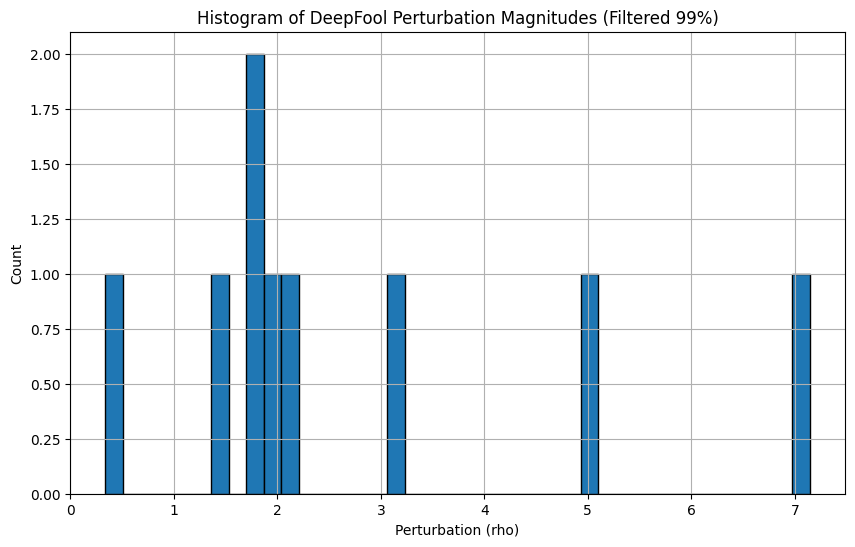

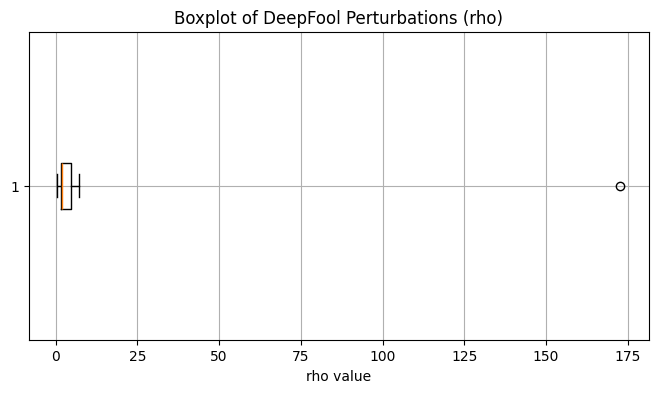

In [7]:
# Combine all perturbations from each fold
all_rhos = []

for r in results['fold_rhos']:
    if not np.isnan(r):
        all_rhos.append(r)

all_rhos = np.array(all_rhos)

print("=== Statistics for DeepFool perturbations ===")
print(f"Count: {len(all_rhos)}")
print(f"Mean: {np.mean(all_rhos):.4f}")
print(f"Median: {np.median(all_rhos):.4f}")
print(f"Standard deviation: {np.std(all_rhos):.4f}")
print(f"Min: {np.min(all_rhos):.4f}")
print(f"Max: {np.max(all_rhos):.4f}")

# -----------------------------
# Histogram
# -----------------------------
import matplotlib.pyplot as plt

# Filter extreme outliers for visualization
filtered_rhos = all_rhos[all_rhos < np.percentile(all_rhos, 99)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_rhos, bins=40, edgecolor='black')
plt.title("Histogram of DeepFool Perturbation Magnitudes (Filtered 99%)")
plt.xlabel("Perturbation (rho)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# -----------------------------
# Boxplot
# -----------------------------
plt.figure(figsize=(8, 4))
plt.boxplot(all_rhos, vert=False, showfliers=True)
plt.title("Boxplot of DeepFool Perturbations (rho)")
plt.xlabel("rho value")
plt.grid(True)
plt.show()


**Histograma das Perturbações (rho) Filtradas**

Ao filtrar o 1% superior (o outlier), o histograma confirma que as perturbações necessárias para enganar o modelo são, na maioria dos casos, extremamente pequenas (ρ<10).

A maior frequência de ρ está entre 1.5 e 2.0 (o que é consistente com a mediana de ≈2.08)

**Boxplot das Perturbações (rho)**
O boxplot demonstra que a maioria dos dados (ρ) está concentrada próxima de zero (mediana ≈2.08).

O ponto isolado do lado direito, perto de 175, é o outlier (provavelmente o Fold 3) que inflaciona a média e o desvio padrão.

Isto sugere que, para quase todas as amostras, uma perturbação mínima foi suficiente para enganar o modelo, exceto para uma ou poucas divisões dos dados onde o modelo demonstrou ser muito mais robusto.

### **Conclusão**

Ao aplicar o DeepFool, observamos que pequenas perturbações podem alterar algumas predições, o que é esperado em modelos de aprendizagem profunda. No entanto, a maioria das amostras requer apenas ajustes mínimos para serem afetadas, enquanto algumas poucas exigem mudanças maiores, indicando que o modelo tem capacidade de reconhecer padrões complexos em muitos casos.

Resumindo, o modelo apresenta desempenho consistente e robusto em termos de classificação, e o DeepFool fornece insights valiosos sobre a sensibilidade do modelo, permitindo futuras melhorias de robustez de forma direcionada.